In [1]:
import heeps
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from heeps.pupil.create_lyotstop import create_ls
from heeps.util.img_processing import resize_img, pad_img, crop_img, oversamp
from heeps.util.round2 import round2odd
from heeps.util.multiCPU import multiCPU
from copy import deepcopy
import proper.prop_get_amplitude as get_amplitude
from scipy.interpolate import interp2d
from astropy.io import fits
import astropy.convolution as astroconv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
import warnings
%matplotlib inline

### Inputs

In [2]:
pupil_img_size = 39.9988    # pupil image in m
nimg = 10526                # size of the high-res pupil image
print('pupil_img_size = %s m'%pupil_img_size)
print('nimg = %s'%nimg)
# nominal diameters
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
# averaged full-M1 diameters
diam_fullM1_ext = 37.812
diam_fullM1_int = 10.196
# RA optimal diameter
diam_ravc_opt = 18.637 # (r_opt=0.505)
# spider width in m
spi_width = 0.54
# 2D map
npup = 41
nspi = 41
rp = np.linspace(0, 0.06, npup)
rs = np.linspace(0, 0.06, nspi)
# METIS "pupil image" size in mm
pupil_img_size_METIS = {'IMG': 45/diam_nominal_ext*pupil_img_size, 
                        'LMS': 28/diam_nominal_ext*pupil_img_size}
print('pupil_img_size_METIS = %s mm'%dict((x, round(y, 2)) 
    for x, y in pupil_img_size_METIS.items()))
# Huygens PSF data
dir_data = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/pupil_blurring/data'))
nkernel = 127
data_spacing = 0.014239     # in mm
samp = dict((x, oversamp(nimg, y/data_spacing, precision=1e-2, to_odd=True))
    for x, y in pupil_img_size_METIS.items())
nimg_pad = dict((x, y[0]) for x, y in samp.items())
npup_conv = dict((x, y[1]) for x, y in samp.items())
print('nimg = %s'%nimg)
print('nimg_pad = %s'%nimg_pad)
print('npup_conv = %s'%npup_conv)
# parameters at each band
phot_spiders = {'L' :3.5,   # pixels on the spiders (for 1 inside the pupil)
                'N2':4.3}
phot_envirnt = {'L' :4.3,   # pixels outside the pupil (for 1 inside the pupil)
                'N2':5.1}
npupil = {'L': update_config(**dict(read_config(), band='L'))['npupil'],
          'N2':update_config(**dict(read_config(), band='N2'))['npupil']}
pupil_scaling = 4
print('npupil = %s'%npupil)
print('pupil_scaling = %s'%pupil_scaling)
title_bkg = 'Relative additionnal flux from blurred background\n(sweetspot %s)'
title_vpm = 'Relative additionnal VPM leakage from blurred pupil\n(sweetspot %s)'
title_vpm2 = 'VPM leakage from blurred pupil\n(sweetspot %s)'
title_app = 'APP blurred pupil flux uniformity/peak-to-valley\n(sweetspot %s)'

pupil_img_size = 39.9988 m
nimg = 10526
pupil_img_size_METIS = {'IMG': 46.7, 'LMS': 29.06} mm
nimg = 10526
nimg_pad = {'IMG': 10562, 'LMS': 10682}
npup_conv = {'IMG': 3291, 'LMS': 2071}
npupil = {'L': 285, 'N2': 119}
pupil_scaling = 4


### Create pupils

In [3]:
eso = os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil/eso'))
maskM1 = fits.getdata(os.path.join(eso, 'mask_fullM1.fits'))
spiders = fits.getdata(os.path.join(eso, 'SpiderShadow.fits'))
pickle_M1 = os.path.join(eso, 'pup_M1.pkl')
if os.path.isfile(pickle_M1):
    pup_M1 = pickle.load(open(pickle_M1,'rb'))
else:
    pup_M1 = dict((x, resize_img(pad_img(maskM1*spiders, y), z))
                for (x, y), (x, z) in zip(nimg_pad.items(), npup_conv.items()))
    with open(pickle_M1, 'wb') as file:
        pickle.dump(pup_M1, file)
        file.close()
pickle_bkg = os.path.join(eso, 'pup_bkg.pkl')
if os.path.isfile(pickle_bkg):
    pup_bkg = pickle.load(open(pickle_bkg,'rb'))
else:
    pup_bkg = dict((x, dict((band, resize_img(pad_img(maskM1*((1 - spiders)*phot_spi) 
                    + (1 - maskM1)*phot_env, y), z)) 
                    for (band, phot_spi), (band, phot_env) 
                    in zip(phot_spiders.items(), phot_envirnt.items())))
                for (x, y), (x, z) in zip(nimg_pad.items(), npup_conv.items()))
    with open(pickle_bkg, 'wb') as file:
        pickle.dump(pup_bkg, file)
        file.close()

### Define functions

In [4]:
def conv_pupil(conf, plane, data, i, geometric_spacing=0.0004):
    band = conf['band']
    filename = conf['dir_output'] + 'data_%s_npad_vpm.fits'%i
    if os.path.isfile(filename):
        kernel = fits.getdata(conf['dir_output'] + 'data_%s_kernel.fits'%i)
        pup_bkg_conv = fits.getdata(conf['dir_output'] + 'data_%s_pup_bkg_conv.fits'%i)
        pup_conv = fits.getdata(conf['dir_output'] + 'data_%s_pup_conv.fits'%i)
        kernel_vpm = fits.getdata(conf['dir_output'] + 'data_%s_kernel_vpm.fits'%i)
        pup_vpm = fits.getdata(conf['dir_output'] + 'data_%s_pup_vpm.fits'%i)
        npad_vpm = fits.getdata(conf['dir_output'] + 'data_%s_npad_vpm.fits'%i)[0]
        nkernel_vpm = kernel_vpm.shape[0]
        npup_vpm = pup_vpm.shape[0]
    else:
        # 1/ load kernel (Huygens PSF)
        if 'geometric' in data:
            pad_kernel = round(nkernel*data_spacing/geometric_spacing)
            kernel = np.loadtxt(data%i , delimiter='\t', skiprows=5)[1:,1:]
            kernel /= np.max(kernel)
            kernel = resize_img(pad_img(kernel, pad_kernel), nkernel)
        else:
            kernel = np.loadtxt(data%i, delimiter='\t', encoding='utf-16', skiprows=21)[1:,1:]
        # 2/ convolve background thermal emission with kernel
        if 'geometric' in data:
            pup_bkg_conv = np.array([[0]])
        else:
            pup_bkg_conv = astroconv.convolve(pup_bkg[plane][band], kernel, boundary='extend')
        # 3/ convolve M1 pupil with kernel
        pup_conv = astroconv.convolve(pup_M1[plane], kernel, boundary='extend')
        # 4/ resample kernel
        nkernel_vpm = round2odd(nkernel*pupil_scaling*npupil[band]/npup_conv[plane])
        npup_vpm = npup_conv[plane]*nkernel_vpm/nkernel
        npad_vpm, npup_vpm = oversamp(nimg, npup_vpm, precision=1e-2, to_odd=True)
        kernel_vpm = resize_img(kernel, nkernel_vpm)
        pup_vpm = resize_img(pad_img(maskM1*spiders, npad_vpm), npup_vpm)
        fits.writeto(conf['dir_output'] + 'data_%s_kernel.fits'%i, kernel)
        fits.writeto(conf['dir_output'] + 'data_%s_pup_bkg_conv.fits'%i, pup_bkg_conv)
        fits.writeto(conf['dir_output'] + 'data_%s_pup_conv.fits'%i, pup_conv)
        fits.writeto(conf['dir_output'] + 'data_%s_kernel_vpm.fits'%i, kernel_vpm)
        fits.writeto(conf['dir_output'] + 'data_%s_pup_vpm.fits'%i, pup_vpm)
        fits.writeto(conf['dir_output'] + 'data_%s_npad_vpm.fits'%i, np.array([npad_vpm]))
    print('background:')
    print('   nkernel = %s, npup_conv = %s'%(nkernel, npup_conv[plane]))
    print('HCI:')
    print('   nkernel_vpm = %s, npup_vpm = %s\n'%(nkernel_vpm, npup_vpm))
    # 5/ figure
    c = pup_conv.shape[0]/2
    cext = c/pupil_img_size*diam_allglass_ext
    cint = c/pupil_img_size*diam_allglass_int
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.1, 1, 1])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # divide by zero encountered in log10
        plt.subplot(gs[0]); plt.title('kernel (log10)')
        plt.imshow(np.log10(kernel), origin='lower', cmap='inferno')
        plt.colorbar(cax=fig.add_axes([0.33, 0.17, 0.01, 0.65]))
        vmin, vmax = -1, 1 #log10
        plt.subplot(gs[2]); plt.title('blurred background (log10)')
        plt.imshow(np.log10(pup_bkg_conv), origin='lower', vmin=vmin, vmax=vmax)
        ax[2].add_patch(plt.Circle((c,c), cext, color='red', fill=False))
        ax[2].add_patch(plt.Circle((c,c), cint, color='red', fill=False))
        plt.subplot(gs[3]); plt.title('blurred pupil (log10)')
        plt.imshow(np.log10(pup_conv), origin='lower', vmin=vmin, vmax=vmax)
        ax[3].add_patch(plt.Circle((c,c), cext, color='red', fill=False))
        ax[3].add_patch(plt.Circle((c,c), cint, color='red', fill=False))
    plt.colorbar(cax=fig.add_axes([0.85, 0.17, 0.01, 0.65]))
    plt.subplots_adjust(right=0.84) # for colorbar
    plt.savefig(conf['dir_output'] + 'data_%s_blurring.png'%i, dpi=300, transparent=True)
    return pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm

def cold_stop(conf, r_pup, r_spi, circ_int=False, dRint=0.08):
    # RAVC case (circ_int set to True)
    diam_int = diam_ravc_opt if circ_int == True else diam_allglass_int
    # CVC case (ls_dRint set to None)
    dRint = dRint if conf['ls_dRint'] is None else r_pup
    # create cold stop
    cs = create_ls(diam_allglass_ext, diam_int, dRext=r_pup, dRint=dRint, dRspi=r_spi,
                    circ_ext=False, circ_int=circ_int, **conf)
    return cs

def get_blur_sharp(conf, pup_bkg_conv, pup_conv, conf_vpm, amp1, amp2, r_pup, r_spi):
    # background case
    if pup_bkg_conv.shape != (0, 0):
        # flux from sharp background
        cs = cold_stop(conf, r_pup, r_spi)
        bkg_sharp = np.sum(cs)
        # relative flux from blurred background
        bkg_blur = np.sum(cs*pup_bkg_conv)/bkg_sharp
    elif 'APP' in conf['mode']:
        cs = cold_stop(conf, r_pup, r_spi)
    # HCI case
    I_blur, I_sharp = 0, 0
    if 'VC' in conf['mode']:
        if 'CVC' in conf['mode']:
            conf_vpm['ls_dRint'] = None
        # flux from sharp pupil
        cs_vpm = cold_stop(conf_vpm, r_pup, r_spi, circ_int=('RAVC' in conf['mode']))
        # sharp leakage
        I_sharp = np.sum((cs_vpm*amp1)**2)
        # blurred leakage
        I_blur = np.sum((cs_vpm*amp2)**2)
        # relative leakage from blurred pupil
        hci_blur = (I_blur/I_sharp) - 1
        hci_sharp = np.sum(cs_vpm)
    elif 'APP' in conf['mode']:
        # p2v flux from blurred pupil
        hci_sharp = bkg_sharp
        hci_blur = np.round(cs).astype(int)*pup_conv
        hci_blur = 1 - np.min(hci_blur[hci_blur!=0])
    return bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp

def get_blur_sharp_2d(conf, pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm,
        i, rs, rp, plane='IMG'):
    filename = conf['dir_output'] + 'data_%s_hci_blur.fits'%i
    if os.path.isfile(filename):
        bkg_blur = fits.getdata(conf['dir_output'] + 'data_%s_bkg_blur.fits'%i)
        bkg_sharp = fits.getdata(conf['dir_output'] + 'data_%s_bkg_sharp.fits'%i)
        hci_blur = fits.getdata(conf['dir_output'] + 'data_%s_hci_blur.fits'%i)
        hci_sharp = fits.getdata(conf['dir_output'] + 'data_%s_hci_sharp.fits'%i)
        I_blur = fits.getdata(conf['dir_output'] + 'data_%s_I_blur.fits'%i)
        I_sharp = fits.getdata(conf['dir_output'] + 'data_%s_I_sharp.fits'%i)
    else:
        conf_vpm = deepcopy(conf)
        conf['npupil'] = pup_conv.shape[0]
        conf['pupil_img_size'] *= nimg_pad[plane]/nimg
        amp1, amp2 = 0, 0
        if 'VC' in conf['mode']:
            npupil_scaled = pupil_scaling*conf_vpm['npupil']
            conf_vpm['npupil'] = pup_vpm.shape[0]
            conf_vpm['ngrid'] *= pupil_scaling
            conf_vpm['pupil_img_size'] *= npad_vpm/nimg
            conf_vpm['pscale'] *= conf_vpm['npupil']/npupil_scaled*nimg/npad_vpm
            conf_vpm = heeps.config.update_config(**conf_vpm, verbose=True)
            wf = heeps.pupil.pupil(pup=pup_vpm, **conf_vpm, verbose=True)
            wf = heeps.optics.apodizer(wf, **conf_vpm, verbose=True)
            wf = heeps.optics.fp_mask(wf, **conf_vpm, verbose=True)
            amp1 = crop_img(get_amplitude(wf), conf_vpm['npupil'])
            amp2 = astroconv.convolve(amp1, kernel_vpm, boundary='extend')
        out1, out2, out3, out4, out5, out6 = multiCPU(get_blur_sharp, nout=4,
            posargs=[conf, pup_bkg_conv, pup_conv, conf_vpm, amp1, amp2],
            posvars=[np.repeat(rp, nspi), np.tile(rs, npup)], verbose=True)
        bkg_blur = out1.reshape(npup, nspi)
        bkg_sharp = out2.reshape(npup, nspi)
        hci_blur = out3.reshape(npup, nspi)
        hci_sharp = out4.reshape(npup, nspi)
        I_blur = out5.reshape(npup, nspi)
        I_sharp = out6.reshape(npup, nspi)
        fits.writeto(conf['dir_output'] + 'data_%s_bkg_blur.fits'%i, bkg_blur)
        fits.writeto(conf['dir_output'] + 'data_%s_bkg_sharp.fits'%i, bkg_sharp)
        fits.writeto(conf['dir_output'] + 'data_%s_hci_blur.fits'%i, hci_blur)
        fits.writeto(conf['dir_output'] + 'data_%s_hci_sharp.fits'%i, hci_sharp)
        fits.writeto(conf['dir_output'] + 'data_%s_I_blur.fits'%i, I_blur)
        fits.writeto(conf['dir_output'] + 'data_%s_I_sharp.fits'%i, I_sharp)
    return bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp

def plot_2d_map(conf, blur, thruput, i, rs, rp, rs_opt, rp_opt, title):
    _, ax = plt.subplots(figsize = (8,6))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # divide by zero encountered in log10
        plt.imshow(np.log10(blur), origin='lower', aspect='auto', 
                   cmap='viridis', extent=(rs[0],rs[-1],rp[0],rp[-1]))
    plt.plot(rs, rs, ':', color='white')
    plt.colorbar()
    f_blur = interp2d(rs, rp, blur)
    f_thruput = interp2d(rs, rp, thruput)
    optim = f_blur(rs_opt, rp_opt)
    def fmt(x, optim=optim):
        return '%.2e'%10**(x) if np.isclose(10**x, optim) else '%.0e'%10**(x)
    print('intersect = %s (%.2f%%, %.2f%%)'
        %(fmt(np.log10(optim)), rs_opt*100, rp_opt*100))

    cs_min = max(np.nanmin(blur), 1e-6)
    cs_max = np.nanmax(blur)
    cs_min = int(np.ceil(np.log10(cs_min)))
    cs_max = int(np.floor(np.log10(cs_max)))
    cs_vals = np.append(np.log10(optim), np.arange(cs_min, cs_max + 1))
    cs_ls = np.append(':', ['-']*(len(cs_vals) - 1))
    cs_ls = cs_ls[np.argsort(cs_vals)]
    cs_vals = np.sort(cs_vals)
    CS = ax.contour(np.log10(blur), cs_vals, colors='magenta', linewidths=2, 
        linestyles=cs_ls, extent=(rs[0],rs[-1],rp[0],rp[-1]))
    lx = []
    ly = []
    for j,c in enumerate(CS.collections):
        v = c.get_paths()[0].vertices
        x = v[:,0]
        y = v[:,1]
        t = np.array([f_thruput(s,p) for s,p in zip(x,y)])
        k = np.argmax(t)
        plt.scatter(x[k], y[k], s=150, c='magenta', marker='+')
        print('optim %s = %s (%.2f%%, %.2f%%)'
            %(j, fmt(cs_vals[j]), x[k]*100, y[k]*100))
        lx.append(x[k]+3e-3)
        ly.append(y[k]-1e-3)

    manual = np.array([lx,ly]).T
    ax.clabel(CS, CS.levels, fontsize=12, inline=True, manual=manual, fmt=fmt)

    #plt.scatter(rs_opt, rp_opt, s=150, c='red', marker='+')
    plt.xlim(rs[0], rs[-1])
    plt.ylim(rp[0], rp[-1])
    plt.xlabel('ls_dRspi')
    plt.ylabel('ls_dRext & ls_dRint')
    plt.title(title)
    #ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
    #ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
    tag = 'bkg' if 'background' in title else 'hci'
    plt.savefig(conf['dir_output'] + 'data_%s_2d_map_%s.png'
        %(i, tag), dpi=300, transparent=True)

# IMG 6" circular (L-band VPM)

In [5]:
# optimal lyot stop params
rs_opt = 0.0207#0.0333#0.0317
rp_opt = 0.0207#0.0307#0.0291
# initialize conf for HEEPS
conf = dict(
        dir_output = 'output_files/pupil_blurring/IMG_L_field_6',
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        band = 'L',
        mode = 'RAVC',
        ravc_calc = False,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.2568
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)



### IMG_VPM_sweetspot1_pp1.txt

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 43, npup_vpm = 1131



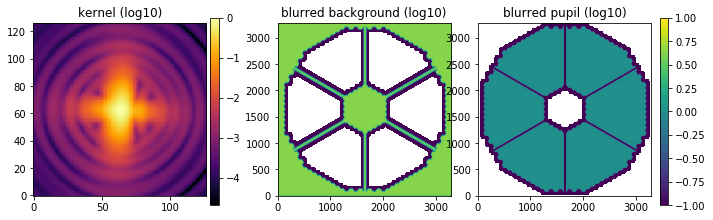

In [6]:
data = os.path.join(dir_data, 'IMG_VPM_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, data_i, rs, rp)

intersect = 1.31e-03 (2.07%, 2.07%)
optim 0 = 1e-06 (4.95%, 5.65%)
optim 1 = 1e-05 (4.39%, 4.80%)
optim 2 = 1e-04 (3.57%, 3.60%)
optim 3 = 1e-03 (2.27%, 2.25%)
optim 4 = 1.31e-03 (2.10%, 2.03%)
optim 5 = 1e-02 (0.65%, 0.75%)


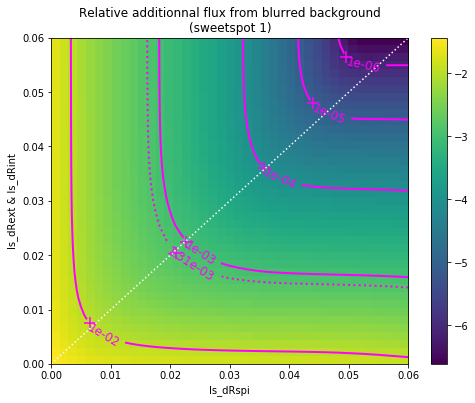

In [7]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

intersect = 3.23e-02 (2.07%, 2.07%)
optim 0 = 1e-06 (0.25%, 0.00%)
optim 1 = 1e-05 (0.18%, 0.00%)
optim 2 = 1e-04 (0.15%, 0.00%)
optim 3 = 1e-03 (0.00%, 0.17%)


/home/cdelacroix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: RuntimeWarning: invalid value encountered in log10


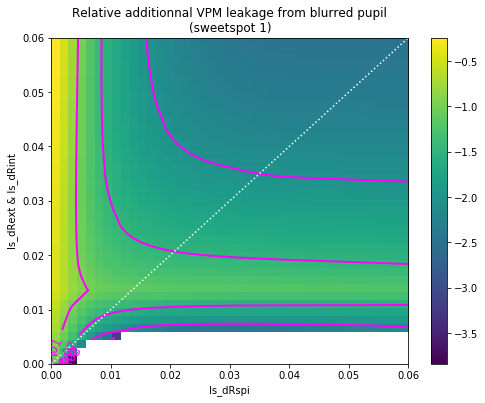

In [8]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

intersect = 1.47e-03 (2.07%, 2.07%)
optim 0 = 1e-03 (0.75%, 3.84%)
optim 1 = 1.47e-03 (0.60%, 2.26%)


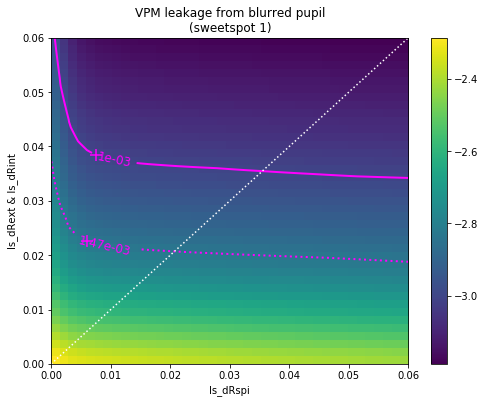

In [9]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)

### IMG_VPM_sweetspot2_pp1.txt

### IMG_VPM_sweetspot3_pp1.txt

### IMG_10.85_sweetspot1_pp1.txt (no diffraction)

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 43, npup_vpm = 1131



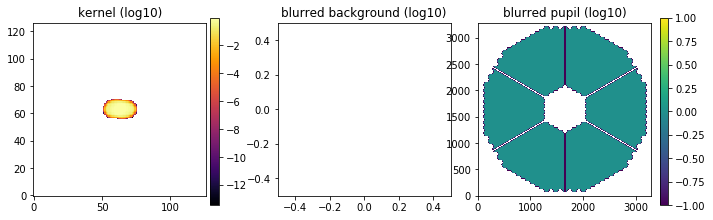

In [10]:
conf['dir_output'] = conf['dir_current'] + '/output_files/pupil_blurring/IMG_L_field_6_no_diffract/'
data = os.path.join(dir_data, 'geometric/IMG_10.85_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, data_i, rs, rp)

intersect = 2.39e-03 (2.07%, 2.07%)
optim 0 = 1e-06 (0.75%, 3.39%)
optim 1 = 1e-05 (5.83%, 1.20%)
optim 2 = 1e-04 (0.07%, 0.37%)
optim 3 = 1e-03 (0.00%, 2.38%)


/home/cdelacroix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: RuntimeWarning: invalid value encountered in log10


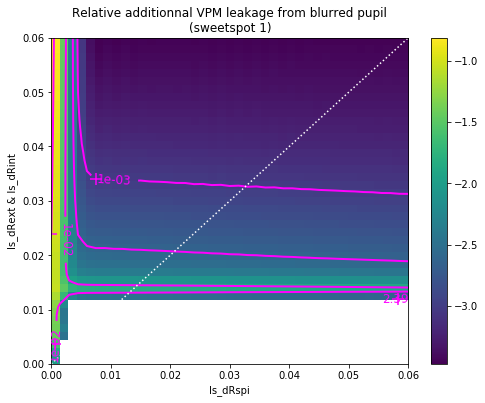

In [11]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

intersect = 1.42e-03 (2.07%, 2.07%)
optim 0 = 1e-03 (0.30%, 3.69%)
optim 1 = 1.42e-03 (0.15%, 2.25%)


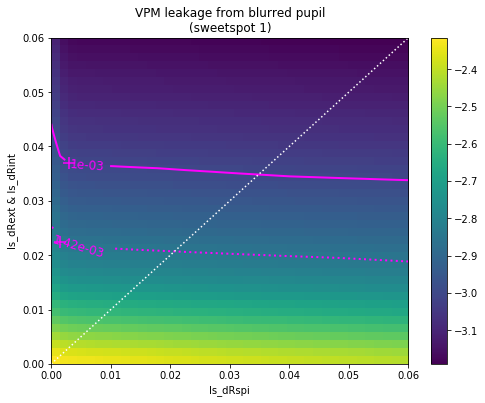

In [12]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)

# IMG 10.85" (L-band img classical + APP)

In [13]:
# optimal lyot stop params
rs_opt = 0.0391#0.0517
rp_opt = 0.0391#0.0491
# initialize conf for HEEPS
conf = dict(
        dir_output = 'output_files/pupil_blurring/IMG_L_field_10.85',
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        band = 'L',
        mode = 'APP',
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)

### IMG_10.85_sweetspot1_pp1.txt

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 43, npup_vpm = 1131



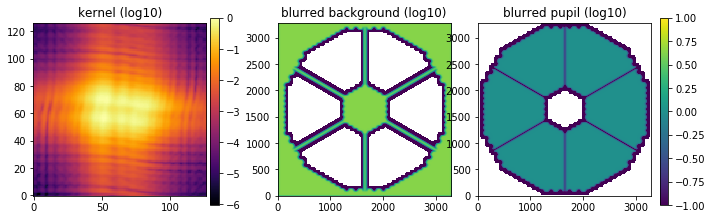

In [14]:
data = os.path.join(dir_data, 'IMG_10.85_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, data_i, rs, rp)

intersect = 1.67e-05 (3.91%, 3.91%)
optim 0 = 1e-06 (4.20%, 5.11%)
optim 1 = 1e-05 (3.75%, 4.35%)
optim 2 = 1.67e-05 (3.75%, 4.00%)
optim 3 = 1e-04 (3.23%, 3.30%)
optim 4 = 1e-03 (2.14%, 2.25%)
optim 5 = 1e-02 (1.05%, 0.97%)


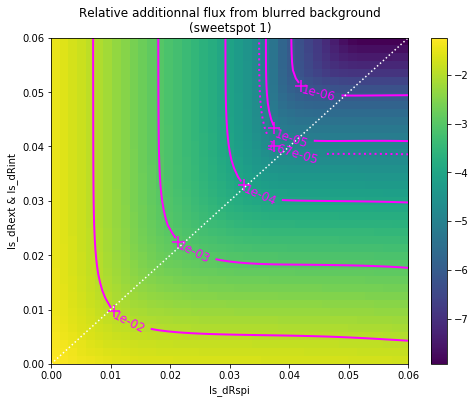

In [15]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

intersect = 5.97e-03 (3.91%, 3.91%)
optim 0 = 1e-04 (3.98%, 5.40%)
optim 1 = 1e-03 (3.55%, 4.95%)
optim 2 = 5.97e-03 (2.71%, 4.05%)
optim 3 = 1e-02 (2.40%, 3.60%)
optim 4 = 1e-01 (1.35%, 2.39%)


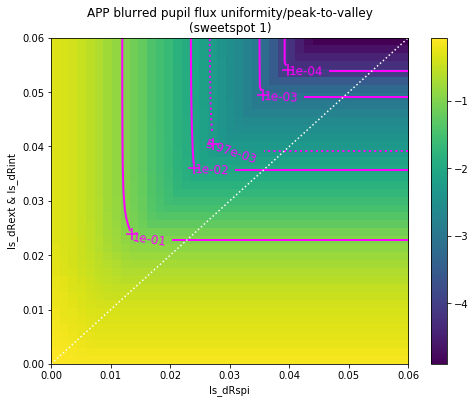

In [16]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_app%data_i)

### IMG_10.85_sweetspot2_pp1.txt

### IMG_10.85_sweetspot3_pp1.txt

### IMG_10.85_sweetspot1_pp1.txt (no diffraction)

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 43, npup_vpm = 1131



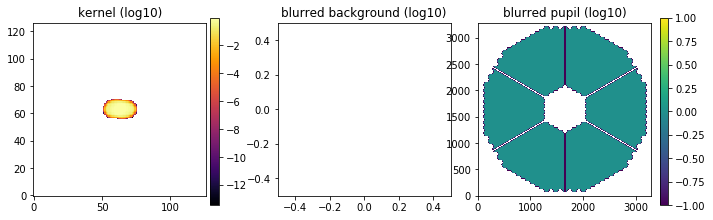

In [17]:
conf['dir_output'] = conf['dir_current'] + '/output_files/pupil_blurring/IMG_L_field_10.85_no_diffract/'
data = os.path.join(dir_data, 'geometric/IMG_10.85_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, data_i, rs, rp)

/home/cdelacroix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: divide by zero encountered in log10
/home/cdelacroix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: divide by zero encountered in log10
/home/cdelacroix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: RuntimeWarning: divide by zero encountered in log10


intersect = 0.00e+00 (3.91%, 3.91%)
optim 0 = 0.00e+00 (0.58%, 1.80%)
optim 1 = 1e-06 (0.51%, 1.80%)
optim 2 = 1e-05 (0.45%, 1.62%)
optim 3 = 1e-04 (0.28%, 1.35%)


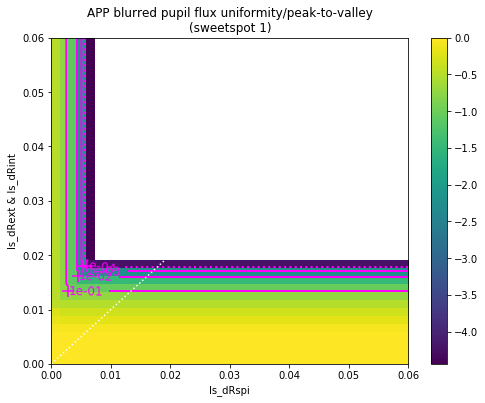

In [18]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_app%data_i)

# IMG 14" (N-band img classical + VPM)

In [19]:
# optimal lyot stop params
rs_opt = 0.0519#0.0645
rp_opt = 0.0519#0.0619
# initialize conf for HEEPS
conf = dict(
        dir_output = 'output_files/pupil_blurring/IMG_N_field_14',
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_lyot_stop = '',
        band = 'N2',
        mode = 'CVC',
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)

### IMG_14_sweetspot1_pp1.txt

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 19, npup_vpm = 493



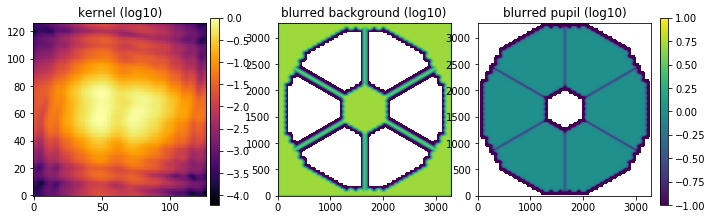

In [20]:
data = os.path.join(dir_data, 'IMG_14_sweetspot%s_pp1.txt')
data_i = 1
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, data_i, rs, rp)

intersect = 2.83e-06 (5.19%, 5.19%)
optim 0 = 1e-06 (4.80%, 5.59%)
optim 1 = 2.83e-06 (4.52%, 5.40%)
optim 2 = 1e-05 (4.33%, 4.95%)
optim 3 = 1e-04 (3.75%, 4.03%)
optim 4 = 1e-03 (3.00%, 2.97%)
optim 5 = 1e-02 (1.80%, 1.63%)


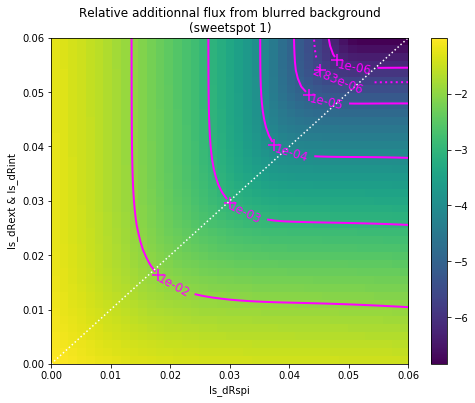

In [21]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

intersect = 3.97e-03 (5.19%, 5.19%)
optim 0 = 3.97e-03 (4.00%, 5.40%)
optim 1 = 1e-02 (2.51%, 0.00%)
optim 2 = 1e-01 (0.55%, 0.00%)


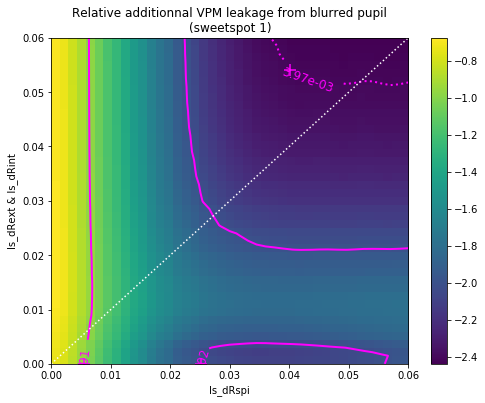

In [22]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

intersect = 2.22e-02 (5.19%, 5.19%)
optim 0 = 2.22e-02 (6.00%, 2.58%)


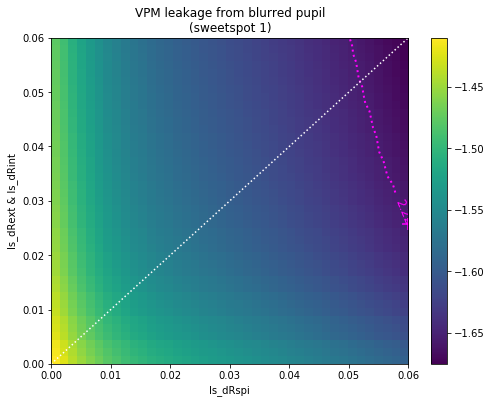

In [23]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)

### IMG_14_sweetspot2_pp1.txt

In [ ]:
data_i = 2
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, data_i, rs, rp)

background:
   nkernel = 127, npup_conv = 3291
HCI:
   nkernel_vpm = 19, npup_vpm = 493

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=4096, diam_norm=1.0853, beam_ratio=0.1073
   npupil=477, pscale=6.79 mas, lam=1.1322E-05 m
   hfov=1.1 arcsec (-> ndet=325, 17.44 lam/D)

Load pupil data from 'pup'
   apply vortex phase mask
   2022-04-01 14:53:47, using 56 cores


In [ ]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

In [ ]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

In [ ]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)

### IMG_14_sweetspot3_pp1.txt

In [ ]:
data_i = 3
pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm = conv_pupil(conf, 'IMG', data, data_i)
bkg_blur, bkg_sharp, hci_blur, hci_sharp, I_blur, I_sharp = get_blur_sharp_2d(
    deepcopy(conf), pup_bkg_conv, pup_conv, pup_vpm, kernel_vpm, npad_vpm, data_i, rs, rp)

In [ ]:
plot_2d_map(conf, bkg_blur, bkg_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_bkg%data_i)

In [ ]:
plot_2d_map(conf, hci_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm%data_i)

In [ ]:
plot_2d_map(conf, I_blur, hci_sharp, data_i, rs, rp, rs_opt=rs_opt, rp_opt=rp_opt, title=title_vpm2%data_i)